In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn import manifold

from keras.models import *
from keras.layers import *
from keras.utils import np_utils

Using TensorFlow backend.


(8820, 60)
(2205, 60, 4)


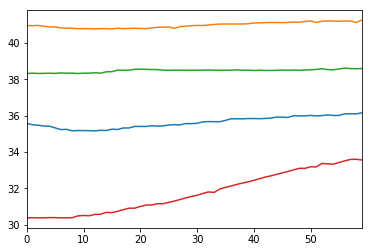

In [2]:
### LOAD DATA ###
label = pd.read_csv('./profile.txt', sep='\t', header=None)
data = ['TS1.txt','TS2.txt','TS3.txt','TS4.txt']
df = pd.DataFrame()

#read and concat data
for txt in data:
    read_df = pd.read_csv(txt, sep='\t', header=None)
    df = df.append(read_df)
print(df.shape)

df.loc[0,:].T.plot(legend=None)

#scale data
def scale(df):
    return (df - df.mean(axis=0))/df.std(axis=0)
df = df.apply(scale)

#reshape data for CNN
df = df.sort_index().values.reshape(-1,4,60).transpose(0,2,1)
print(df.shape)

In [3]:
### ENCODE LABEL Y ###
label = np_utils.to_categorical(label[0].factorize()[0])
label.shape

(2205, 3)

In [4]:
### TRAIN TEST SPLIT ###
X_train, X_test, y_train, y_test = train_test_split(df, label, random_state = 42,test_size=0.2)

# MODEL

In [5]:
num_sensors = 4
TIME_PERIODS = 60

model_m = Sequential()
model_m.add(Conv1D(100, 6, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 6, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(3, activation='softmax'))
print(model_m.summary())

model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 55, 100)           2500      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 100)           60100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 160)           96160     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 6, 160)            153760    
_________________________________________________________________
global_average_poolin

In [6]:
BATCH_SIZE = 16
EPOCHS = 10

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      #callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 1411 samples, validate on 353 samples
Epoch 1/10
1411/1411 [==============================] - 2s 2ms/step - loss: 0.2592 - acc: 0.9270 - val_loss: 0.0777 - val_acc: 0.9830
Epoch 2/10
1411/1411 [==============================] - 2s 1ms/step - loss: 0.1240 - acc: 0.9745 - val_loss: 0.0747 - val_acc: 0.9830
Epoch 3/10
1411/1411 [==============================] - 2s 1ms/step - loss: 0.1037 - acc: 0.9731 - val_loss: 0.0621 - val_acc: 0.9802
Epoch 4/10
1411/1411 [==============================] - 2s 1ms/step - loss: 0.1118 - acc: 0.9759 - val_loss: 0.1320 - val_acc: 0.9660
Epoch 5/10
1411/1411 [==============================] - 1s 988us/step - loss: 0.1347 - acc: 0.9731 - val_loss: 0.0888 - val_acc: 0.9802
Epoch 6/10
1411/1411 [==============================] - 1s 1ms/step - loss: 0.1051 - acc: 0.9724 - val_loss: 0.0785 - val_acc: 0.9802
Epoch 7/10
1411/1411 [==============================] - 1s 1ms/step - loss: 0.1111 - acc: 0.9759 - 

In [7]:
model_m.evaluate(X_test, y_test, verbose=1)[1]

441/441 [==============================] - 0s 244us/step


0.9886621315192744

In [8]:
print(classification_report(np.where(y_test != 0)[1], model_m.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       152
           1       0.97      0.99      0.98       135
           2       1.00      0.99      0.99       154

   micro avg       0.99      0.99      0.99       441
   macro avg       0.99      0.99      0.99       441
weighted avg       0.99      0.99      0.99       441



In [9]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

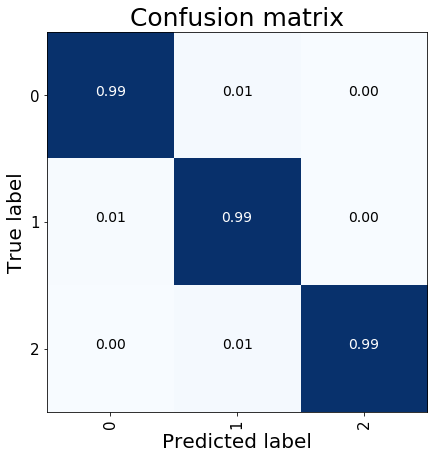

In [10]:
cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], model_m.predict_classes(X_test))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")
plt.show()

# VISUAL REPRESENTATION

In [11]:
### MAKE A MODEL FOR EMBEDDINGS ###
emb_model = Model(inputs=model_m.input, outputs=model_m.get_layer('global_average_pooling1d_1').output)
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1_input (InputLayer)  (None, 60, 4)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 55, 100)           2500      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 100)           60100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 160)           96160     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 6, 160)            153760    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 160)               0         
Total para

In [12]:
### PREPARE DATA TO EXTRACT EMBEDDINGS ###
import tqdm

cycles = []

for cycle in tqdm.tqdm(X_test):
    
    cycle_batch = np.expand_dims(cycle, axis=0)
    cycles.append(cycle_batch)
    
cycles = np.vstack(cycles)

100%|████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 442297.48it/s]


In [13]:
### EXTRACT EMBEDDINGS ###
serie_features = emb_model.predict(cycles)

In [14]:
### VISUALIZE EMBEDDINGS ###
tsne = manifold.TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(serie_features)

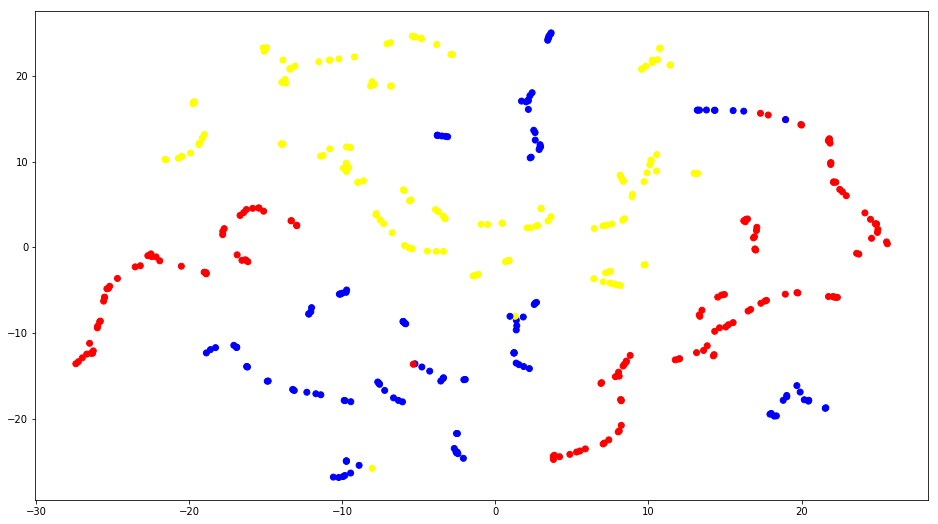

In [15]:
fig, ax = plt.subplots(figsize=(16,9))
colors = {0:'red', 1:'blue', 2:'yellow'}
ax.scatter(T.T[0], T.T[1], c=[colors[i] for i in np.where(y_test != 0)[1]]) 
plt.show()